In [84]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py
from popsycle import synthetic
from astropy.table import Table


import copy

%reload_ext autoreload
%autoreload 2

## Look at comp_dict directly

In [60]:
file_path = 'example_ffp.h5'
with h5py.File(file_path, 'r') as f:
    print(f['l0b0'])

<HDF5 dataset "l0b0": shape (188784,), type "|V232">


In [2]:
#These are the keys inside the lat/long bins
phys_keys = ['zams_mass', 'mass', 'px', 'py', 'pz', 'vx', 'vy', 'vz', 'age',
       'popid', 'exbv', 'glat', 'glon', 'mbol', 'grav', 'teff', 'feh',
       'rad', 'rem_id', 'obj_id', 'ubv_J', 'ubv_H', 'ubv_K', 'ubv_U',
       'ubv_I', 'ubv_B', 'ubv_V', 'ubv_R', 'vr', 'mu_b', 'mu_lcosb']

#this is to keep track of which bin each star came from
phys_keys.append('bin_name')

#these keys don't contain stars so ignore them in the loop creating the df
ignored_keys = {'add_pbh', 'lat_bin_edges', 'long_bin_edges'}


In [3]:
def make_df_from_popsyn(file_path = 'example_ffp.h5'):
    '''
    takes the compact object dictionary after PBHs are injected and returns
    a pandas DataFrame of all stars and their attributes
    '''
    with h5py.File(file_path, 'r') as f:
        
        df = pd.DataFrame(columns=phys_keys)

        for key in list(f.keys()):
            if key not in ignored_keys:
                num_stars = len(np.array(f[key]))

                #0 is a physical quantitiy so initialize with nans
                sub_arr = np.full((num_stars, len(phys_keys)), np.nan)
                #loop through all the stars in this bin and add their attributes to an array
                for i, star in enumerate(np.array(f[key])):
                    sub_arr[i][:-1] = list(star)
                #add the attributes of all the stars from this bin to the master dataframe
                sub_df = pd.DataFrame(sub_arr, columns=phys_keys)
                sub_df['bin_name'] = key
                df = pd.concat([df, sub_df]) 
    
    return df

def sample_ffp_mass(N_ffps: int) -> np.array:
    '''
    This is a dummy function currently. Will want to sample some distribution of masses for the ffps.
    For now, return an array of length N_ffps with fixed mass value in units of solar masses
    '''

    #Jupiter is about 1e-3 solar masses
    return np.ones(N_ffps) * 1e-3

def set_ffp_masses(df_ffps: pd.DataFrame) :
    '''
    Modifies the input dataframe to overwrite the masses of the ffps.
    '''
    N_objects = df_ffps.shape[0]
    masses = sample_ffp_mass(N_objects)
    df_ffps['mass'] = masses
    #PopSyCLE sets Zero age main sequence mass,zams_mass, equal to mass for PBHs. 
    #Following this convention for ffps
    df_ffps['zams_mass'] = masses


def set_ffp_photometry(df_ffps: pd.DataFrame):
    '''
    Modifies the input dataframe to overwrite the photometry of the ffps.
    '''
    N_objects = df_ffps.shape[0]
    photometry_ffps = np.zeros(N_objects)

    df_ffps['ubv_J'] = photometry_ffps
    df_ffps['ubv_H'] = photometry_ffps
    df_ffps['ubv_K'] = photometry_ffps
    df_ffps['ubv_U'] = photometry_ffps
    df_ffps['ubv_I'] = photometry_ffps
    df_ffps['ubv_B'] = photometry_ffps
    df_ffps['ubv_V'] = photometry_ffps
    df_ffps['ubv_R'] = photometry_ffps

def set_ffp_rem_id(df_ffps: pd.DataFrame):
    '''
    Modifies the input dataframe to overwrite the remnant id of the ffps.
    '''
    N_objects = df_ffps.shape[0]
    #pbhs are highest remnant id implemented in popsycle so far so set ffps to 105
    rem_ids = np.ones(N_objects) * 105
    df_ffps['rem_id'] = rem_ids

def set_ffp_pop_id(df_ffps: pd.DataFrame):
    '''
    Modifies the input dataframe to overwrite the pop id of the ffps.
    Set it to 10 since this is what is done for PBHs
    '''
    N_objects = df_ffps.shape[0]
    #Population ID (e.g. Disk, Halo, Bulge. See https://galaxia.sourceforge.net/Galaxia3pub.html for details) 'popid'.
    pop_ids = np.ones(N_objects) * 10

def set_ffp_misc(df_ffps: pd.DataFrame) -> pd.DataFrame:
    '''
    Modifies the input dataframe to overwrite some miscilanious attributes of the ffps
    that are not relevant for us. Set them to NaNs (this is what is done for PBHs I believe)
    '''

    # Bolometric magnitude: mbol, 
    # Surface gravity: grav,
    # Metalicity: feh,
    # log(age/yr): 'age',
    # Effective temperature: teff
    # Galactic Extinsion 'exbv'


    N_objects = df_ffps.shape[0]
    misc_ffps_nans = np.full(N_objects, np.NaN)
   
    df_ffps['mbol'] = misc_ffps_nans
    df_ffps['grav'] = misc_ffps_nans
    df_ffps['feh'] = misc_ffps_nans
    df_ffps['age'] = misc_ffps_nans
    df_ffps['teff'] = misc_ffps_nans
    df_ffps['exbv'] = misc_ffps_nans


def inject_ffp_params(df_ffps: pd.DataFrame) -> pd.DataFrame:
    '''
    Modifies the input dataframe to overwrite all relevant parameters for ffps
    '''
    set_ffp_masses(df_ffps)
    set_ffp_photometry(df_ffps)
    set_ffp_rem_id(df_ffps)
    set_ffp_misc(df_ffps)
    set_ffp_pop_id(df_ffps)

    #todo
    #Heliocentric velocities (in km/s): 'vx', 'vy', 'vz',
    #Radial velocity and proper motions: 'vr', 'mu_b', 'mu_lcosb'
    # Galactic positions 'rad', 'glat', 'glon'
    # Heliocentric positions: 'px', 'py', 'pz', 
    # positions related by:
    # comp_helio = synthetic.galactic_to_heliocentric(
    #             comp_dict["rad"], comp_dict["glat"], comp_dict["glon"]
    #         )
    #         comp_dict["px"], comp_dict["py"], comp_dict["pz"] = comp_helio
    # Object number within given bin: obj_id - Don't think we care about this but should revisit later - obj_id



In [4]:
df = make_df_from_popsyn('example_ffp.h5')

In [10]:
df.head()

,zams_mass,mass,px,py,pz,vx,vy,vz,age,popid,...,ubv_K,ubv_U,ubv_I,ubv_B,ubv_V,ubv_R,vr,mu_b,mu_lcosb,bin_name
0,0.503571,0.503571,3.631762,0.062991,-0.065598,-20.581390,-24.072226,-12.524226,5.827383,0.0,...,5.792072,11.798287,7.600787,10.721358,9.466644,8.552930,-20.766177,-0.748646,-1.375852,l0b0
1,0.393893,0.393893,4.790543,0.082235,-0.086362,-18.358408,-10.715219,-3.930184,5.544013,0.0,...,6.421209,12.853517,8.287896,11.697989,10.366171,9.388461,-18.465815,-0.187513,-0.457441,l0b0
2,0.095672,0.095672,5.375013,0.092805,-0.097811,7.669304,-35.641441,-15.736011,5.257884,0.0,...,8.649642,18.339668,11.017556,16.098106,14.173828,12.747360,7.337969,-0.611782,-1.402376,l0b0
3,0.103781,0.103781,1.381481,0.024024,-0.025084,-18.424522,-6.588330,-14.462896,6.750011,0.0,...,8.581558,17.990839,10.907817,15.848731,13.963803,12.583215,-18.270712,-2.257165,-0.956019,l0b0
4,0.146732,0.146732,2.826867,0.049280,-0.051460,-30.147104,-21.643343,-0.324761,6.945432,0.0,...,8.443503,16.352642,10.557643,14.792372,13.177802,12.001276,-30.508786,-0.065583,-1.574057,l0b0


In [5]:
#create a copy of the master dataframe to modify with ffp parameters
df_ffps = df.copy(deep=True)

In [6]:
inject_ffp_params(df_ffps)

In [13]:
df_ffps.tail()

,zams_mass,mass,px,py,pz,vx,vy,vz,age,popid,...,ubv_K,ubv_U,ubv_I,ubv_B,ubv_V,ubv_R,vr,mu_b,mu_lcosb,bin_name
189143,0.001,0.001,7.160008,0.126803,-0.126787,167.882674,256.203615,-155.728270,NaN,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,168.009958,-4.581879,7.539078,l1b1
189144,0.001,0.001,15.196527,0.270736,-0.272345,-7.675606,231.402495,50.598976,NaN,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-7.619483,0.701631,3.208929,l1b1
189145,0.001,0.001,8.112759,0.143944,-0.144131,154.171229,-171.403336,-21.046850,NaN,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,154.124665,-0.545463,-4.453540,l1b1
189146,0.001,0.001,9.592876,0.168138,-0.170320,-379.390715,-101.690067,-235.109930,NaN,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-379.348947,-5.167431,-2.231358,l1b1
189147,0.001,0.001,4.779132,0.083884,-0.084865,-121.883350,373.725632,-40.571841,NaN,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-121.756291,-1.790666,16.480960,l1b1


In [14]:
#See how the original dataframe treats PBHs for comparison
df.loc[df['rem_id']==104][['mbol', 'grav', 'feh', 'age', 'teff', 'exbv']]

,mbol,grav,feh,age,teff,exbv
188417,NaN,NaN,NaN,NaN,NaN,NaN
188418,NaN,NaN,NaN,NaN,NaN,NaN
188419,NaN,NaN,NaN,NaN,NaN,NaN
188420,NaN,NaN,NaN,NaN,NaN,NaN
188421,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
189143,NaN,NaN,NaN,NaN,NaN,NaN
189144,NaN,NaN,NaN,NaN,NaN,NaN
189145,NaN,NaN,NaN,NaN,NaN,NaN
189146,NaN,NaN,NaN,NaN,NaN,NaN


Want to set t_eff (temp), all ubvs and ztfs (photometry) = 0, set velocities: vx,vy,vz. set positions: px,pv,pz, rad, glat, glon. Assign new population id popid, sample mass from distribution (zams_mass vs mass are always almost the same it seems)

### Write our custom ffp output h5 file to be read by pop_syn

In [7]:
lat_long_bins = df_ffps['bin_name'].unique()

In [8]:
def get_ignored_keys(file_path = 'example_ffp.h5'):
    with h5py.File(file_path, 'r') as f:
        add_pbh = np.array(f['add_pbh'])
        lat_bin_edges = np.array(f['lat_bin_edges'])
        long_bin_edges = np.array(f['long_bin_edges'])
    return add_pbh, lat_bin_edges, long_bin_edges

def write_ffp_h5(df_combined: pd.DataFrame, output_path: str = 'modified_ffp.h5'):
    '''
    #todo 
    Writes the input dataframe (combined df of pbh-injected pop_syn and our ffp version) to a h5 file in the appropriate format
    for PopSyCLE to calculate the events
    '''
    # keys_to_write = ['add_pbh', 'l0b0', 'l0b1', 'l1b0', 'l1b1', 'lat_bin_edges', 'long_bin_edges']
    add_pbh, lat_bin_edges, long_bin_edges = get_ignored_keys()
    with h5py.File(output_path, 'w') as f:
        f.create_dataset('add_pbh', data=add_pbh)
        f.create_dataset('lat_bin_edges', data=lat_bin_edges)
        f.create_dataset('long_bin_edges', data=long_bin_edges)
        for bin in lat_long_bins:
            df_bin = df_combined.loc[df_combined['bin_name'] == bin]
            #add dataset but exclude bin number since we added this to begin with
            df_vals = np.array(df_bin.values[:,:-1])
            # df_tuple = tuple(tuple(row) for row in df_vals)
            f.create_dataset(bin, data=df_vals, dtype=np.float32)
        

In [10]:
write_ffp_h5(df_ffps, 'modified_ffp.h5')

OSError: Can't write data (no appropriate function for conversion path)

In [ ]:
file_path = 'example_ffp.h5'
with h5py.File(file_path, 'r') as f:
    print(f.keys())
    dat1 = np.array(f['l0b0'])

<KeysViewHDF5 ['add_pbh', 'l0b0', 'l0b1', 'l1b0', 'l1b1', 'lat_bin_edges', 'long_bin_edges']>


In [ ]:
file_path = 'modified_ffp.h5'
with h5py.File(file_path, 'r') as f:
    print(f.keys())
    dat2 = np.array(f['l0b0'])

<KeysViewHDF5 ['add_pbh', 'l0b0', 'lat_bin_edges', 'long_bin_edges']>


## Try again just following what's done in synthetic.py

In [54]:
type(np.ones(10))

numpy.ndarray

In [80]:
def sample_ffp_mass(N_ffps: int) -> np.ndarray:
    '''
    This is a dummy function currently. Will want to sample some distribution of masses for the ffps.
    For now, return an array of length N_ffps with fixed mass value in units of solar masses
    '''

    #Jupiter is about 1e-3 solar masses
    # return np.ones(N_ffps) * 1e-3
    return np.ones(N_ffps) * 1

def set_ffp_masses(ffp_arr: np.ndarray) -> None:
    '''
    Modifies the input dataframe to overwrite the masses of the ffps.
    '''
    N_objects = ffp_arr.shape[0]
    masses = sample_ffp_mass(N_objects)
    ffp_arr['mass'] = masses
    #PopSyCLE sets Zero age main sequence mass,zams_mass, equal to mass for PBHs. 
    #Following this convention for ffps
    ffp_arr['zams_mass'] = masses


def set_ffp_photometry(ffp_arr: np.ndarray) -> None:
    '''
    Modifies the input dataframe to overwrite the photometry of the ffps.
    '''
    N_objects = ffp_arr.shape[0]
    photometry_ffps = np.zeros(N_objects)

    ffp_arr['ubv_J'] = photometry_ffps
    ffp_arr['ubv_H'] = photometry_ffps
    ffp_arr['ubv_K'] = photometry_ffps
    ffp_arr['ubv_U'] = photometry_ffps
    ffp_arr['ubv_I'] = photometry_ffps
    ffp_arr['ubv_B'] = photometry_ffps
    ffp_arr['ubv_V'] = photometry_ffps
    ffp_arr['ubv_R'] = photometry_ffps

def set_ffp_rem_id(ffp_arr: np.ndarray) -> None:
    '''
    Modifies the input dataframe to overwrite the remnant id of the ffps.
    '''
    N_objects = ffp_arr.shape[0]
    #pbhs are highest remnant id implemented in popsycle so far so set ffps to 105
    rem_ids = np.ones(N_objects) * 105
    ffp_arr['rem_id'] = rem_ids

def set_ffp_pop_id(ffp_arr: np.ndarray) -> None:
    '''
    Modifies the input dataframe to overwrite the pop id of the ffps.
    Set it to 10 since this is what is done for PBHs
    '''
    N_objects = ffp_arr.shape[0]
    #Population ID (e.g. Disk, Halo, Bulge. See https://galaxia.sourceforge.net/Galaxia3pub.html for details) 'popid'.
    pop_ids = np.ones(N_objects) * 10

def set_ffp_misc(ffp_arr: np.ndarray) -> None:
    '''
    Modifies the input dataframe to overwrite some miscilanious attributes of the ffps
    that are not relevant for us. Set them to NaNs (this is what is done for PBHs I believe)
    '''

    # Bolometric magnitude: mbol, 
    # Surface gravity: grav,
    # Metalicity: feh,
    # log(age/yr): 'age',
    # Effective temperature: teff
    # Galactic Extinsion 'exbv'


    N_objects = ffp_arr.shape[0]
    misc_ffps_nans = np.full(N_objects, np.NaN)
   
    ffp_arr['mbol'] = misc_ffps_nans
    ffp_arr['grav'] = misc_ffps_nans
    ffp_arr['feh'] = misc_ffps_nans
    ffp_arr['age'] = misc_ffps_nans
    ffp_arr['teff'] = misc_ffps_nans
    ffp_arr['exbv'] = misc_ffps_nans


def inject_ffp_params(ffp_arr: np.ndarray) -> None:
    '''
    Modifies the input numpy array to overwrite all relevant parameters for ffps
    '''
    set_ffp_masses(ffp_arr)
    set_ffp_photometry(ffp_arr)
    set_ffp_rem_id(ffp_arr)
    set_ffp_misc(ffp_arr)
    set_ffp_pop_id(ffp_arr)

    #todo
    #Heliocentric velocities (in km/s): 'vx', 'vy', 'vz',
    #Radial velocity and proper motions: 'vr', 'mu_b', 'mu_lcosb'
    # Galactic positions 'rad', 'glat', 'glon'
    # Heliocentric positions: 'px', 'py', 'pz', 
    # positions related by:
    # comp_helio = synthetic.galactic_to_heliocentric(
    #             comp_dict["rad"], comp_dict["glat"], comp_dict["glon"]
    #         )
    #         comp_dict["px"], comp_dict["py"], comp_dict["pz"] = comp_helio
    # Object number within given bin: obj_id - Don't think we care about this but should revisit later - obj_id



In [94]:
#Create the copied hdf5 file with ffps

hdf5_file = 'example_ffp_copy.h5'
output_hdf5_file = 'modified_ffp.h5'

no_ffp_hdf5_file = h5py.File(hdf5_file, "r")
ffp_hdf5_file = h5py.File(output_hdf5_file, "w")

key_list = list(no_ffp_hdf5_file)
key_list = [key for key in key_list if key not in ignored_keys]

hdf5_dset_names = no_ffp_hdf5_file[key_list[0]][:].dtype.names
comp_dtype = synthetic._generate_comp_dtype(hdf5_dset_names)

#If we want to compare to no pbhs, set this to false and use non-pbh h5 as 'hdf5_file'
ffp_hdf5_file["add_pbh"] = True

lat_bin = no_ffp_hdf5_file["lat_bin_edges"][:]
long_bin = no_ffp_hdf5_file["long_bin_edges"][:]

for idx, key in enumerate(key_list):
    key_data = no_ffp_hdf5_file[key][:]
    #copy the stars in this bin (assuming 1 ffp per star implicitly)
    ffp_data_in_key = copy.deepcopy(key_data)
    #modify the copy to use the ffp params
    inject_ffp_params(ffp_data_in_key)
    # combined_data = np.hstack((key_data, ffp_data_in_key))
    # cant use combined data for now because it complains about duplicate postions (l, b)
    # which messes up a nearest neighbors search
    combined_data = ffp_data_in_key

    _ = ffp_hdf5_file.create_dataset(
        key, shape=(combined_data.shape[0],), dtype=comp_dtype, data=combined_data
    )
    
_ = ffp_hdf5_file.create_dataset("lat_bin_edges", (len(lat_bin), 1), data=lat_bin)
_ = ffp_hdf5_file.create_dataset("long_bin_edges", (len(lat_bin), 1), data=long_bin)

no_ffp_hdf5_file.close()
ffp_hdf5_file.close()


In [95]:
file_path = 'modified_ffp.h5'
with h5py.File(file_path, 'r') as f:
    print(f.keys())
    dat2 = np.array(f['l0b0'])

<KeysViewHDF5 ['add_pbh', 'l0b0', 'l0b1', 'l1b0', 'l1b1', 'lat_bin_edges', 'long_bin_edges']>


### Now let's try and calculate events for this new population file

In [96]:
#Make obs_time and area small for testing
mock_roman_params = {"fdm": 1.0, 
                     "pbh_mass":30, 
                     "v_esc":550, 
                     "rho_0":0.0093, 
                     "r_s": 18.6, 
                     "r_max":16.6 , 
                     "gamma": 1.0, 
                    #  "obs_time":1825, 
                     "obs_time":18, 
                     "cadence":3, 
                     "blend_rad": 0.09, 
                     "longitude": 1.00, 
                     "latitude": -1.03, 
                    #  "area": 0.16,
                     "area": 0.0016,
                     "BH_kick_speed_mean": 100,
                     "NS_kick_speed_mean": 350
                     }

In [97]:
#Set to Roman Params from paper
synthetic.calc_events(hdf5_file = 'modified_ffp.h5', 
                      output_root2 = 'modified_ffp_output', 
                      radius_cut = 2,
                      obs_time = mock_roman_params["obs_time"], 
                      n_obs = int(mock_roman_params["obs_time"]/mock_roman_params["cadence"]), 
                      theta_frac = 2, 
                      blend_rad = mock_roman_params["blend_rad"], 
                      overwrite = True, 
                      n_proc = 7,) #adjust based on your number of cores

Working on loop ll, bb =  0 0
Candidate events detected:  56
calc_events runtime : 31.697733 s


There are 16 events when I don't replace values in the dict with ffp values and 56 events when I do inject the ffp values. This drops to 0 when I set all the masses to jupiter mass rather than 1 solar mass. 

In [98]:
synthetic.refine_events(input_root = 'modified_ffp_output', 
                        filter_name = 'I',
                        photometric_system = 'ubv',
                        red_law = 'Damineli16', 
                        overwrite = True, 
                        output_file = 'default')

Original candidate events:  56
Candidate events in survey window:  9
refine_events runtime : 0.190537 s


## Look at the outputs

In [85]:
# t = Table.read('example_refined_events_i_Damineli16.fits')
t = Table.read('modified_ffp_output_refined_events_ubv_I_Damineli16.fits')

print(t.colnames)

['zams_mass_L', 'mass_L', 'px_L', 'py_L', 'pz_L', 'vx_L', 'vy_L', 'vz_L', 'age_L', 'popid_L', 'exbv_L', 'glat_L', 'glon_L', 'mbol_L', 'grav_L', 'teff_L', 'feh_L', 'rad_L', 'rem_id_L', 'obj_id_L', 'ubv_J_L', 'ubv_H_L', 'ubv_K_L', 'ubv_U_L', 'ubv_I_L', 'ubv_B_L', 'ubv_V_L', 'ubv_R_L', 'vr_L', 'mu_b_L', 'mu_lcosb_L', 'zams_mass_S', 'mass_S', 'px_S', 'py_S', 'pz_S', 'vx_S', 'vy_S', 'vz_S', 'age_S', 'popid_S', 'exbv_S', 'glat_S', 'glon_S', 'mbol_S', 'grav_S', 'teff_S', 'feh_S', 'rad_S', 'rem_id_S', 'obj_id_S', 'ubv_J_S', 'ubv_H_S', 'ubv_K_S', 'ubv_U_S', 'ubv_I_S', 'ubv_B_S', 'ubv_V_S', 'ubv_R_S', 'vr_S', 'mu_b_S', 'mu_lcosb_S', 'theta_E', 'u0', 'mu_rel', 't0', 't_E', 'ubv_I_app_S', 'ubv_I_app_L', 'cent_glon_I_N', 'cent_glat_I_N', 'ubv_I_app_N', 'ubv_I_app_LSN', 'delta_m_I', 'f_blend_I', 'pi_rel', 'pi_E']


## Figure out how many events due to BH, NS, WD, star, and FFPS!

In [99]:
ffp_idx = np.where(t['rem_id_L'] == 105)[0]
pbh_idx = np.where(t['rem_id_L'] == 104)[0]
bh_idx = np.where(t['rem_id_L'] == 103)[0]
ns_idx = np.where(t['rem_id_L'] == 102)[0]
wd_idx = np.where(t['rem_id_L'] == 101)[0]
st_idx = np.where(t['rem_id_L'] == 0)[0]
print('Number of FFPs: ' + str(len(ffp_idx)))
print('Number of PBHs: ' + str(len(pbh_idx)))
print('Number of BHs: ' + str(len(bh_idx)))
print('Number of NSs: ' + str(len(ns_idx)))
print('Number of WDs: ' + str(len(wd_idx)))
print('Number of stars: ' + str(len(st_idx)))

Number of FFPs: 9
Number of PBHs: 0
Number of BHs: 0
Number of NSs: 0
Number of WDs: 0
Number of stars: 0


## Histogram of tE

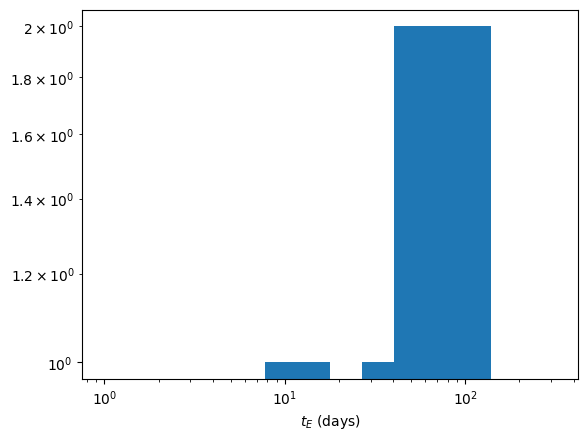

In [89]:
plt.hist(t['t_E'], bins = np.logspace(0, 2.5, 15))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$t_E$ (days)')
plt.show()

## piE vs tE

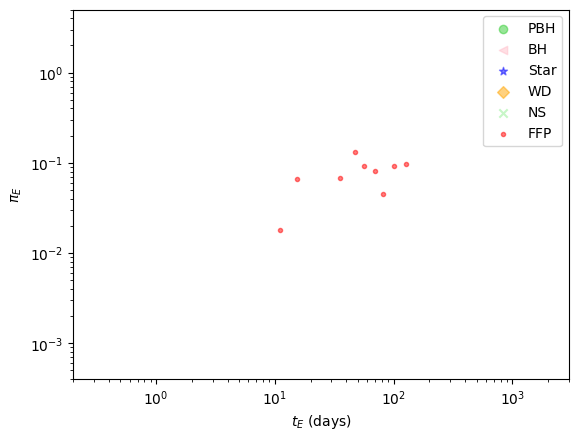

In [90]:
plt.scatter(t['t_E'][pbh_idx], t['pi_E'][pbh_idx], color = 'limegreen', marker='o', label = 'PBH', alpha=0.5)
plt.scatter(t['t_E'][bh_idx], t['pi_E'][bh_idx], color = 'pink', marker='<', label = 'BH', alpha=0.5)
plt.scatter(t['t_E'][st_idx], t['pi_E'][st_idx], color = 'blue', marker='*', label = 'Star', alpha=0.5)
plt.scatter(t['t_E'][wd_idx], t['pi_E'][wd_idx], color = 'orange', marker='D', label = 'WD', alpha=0.5)
plt.scatter(t['t_E'][ns_idx], t['pi_E'][ns_idx], color = 'lightgreen', marker='x', label = 'NS', alpha=0.5)
plt.scatter(t['t_E'][ffp_idx], t['pi_E'][ffp_idx], color = 'red', marker='.', label = 'FFP', alpha=0.5)


plt.xscale('log')
plt.yscale('log')
plt.xlabel('$t_E$ (days)')
plt.ylabel('$\pi_E$')
plt.xlim(2e-1, 3e3)
plt.ylim(4e-4, 5e0)
plt.legend()
plt.show()

## dL vs dS

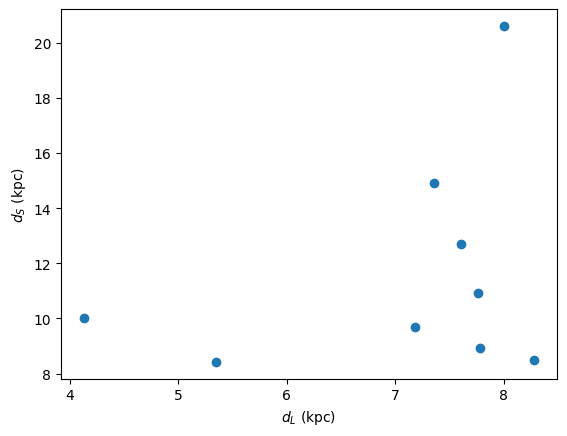

In [100]:
plt.scatter(t['rad_L'], t['rad_S'])
plt.xlabel('$d_L$ (kpc)')
plt.ylabel('$d_S$ (kpc)')
plt.show()